<a href="https://colab.research.google.com/github/hamednasr/deep-learning/blob/main/DUDL_weights_demoinits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning
## SECTION: Weight inits and investigations
### LECTURE: A surprising demonstration of weight initializations
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202109

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [3]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [4]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Explore the weights

In [7]:
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


In [55]:
print('\n\nWeights for layer fc1:')
print(tmpnet.fc1.weight.data)



Weights for layer fc1:
tensor([[ 0.1057, -0.0777, -0.1174,  ..., -0.1065, -0.0963,  0.0809],
        [ 0.0040,  0.0744, -0.0273,  ...,  0.0906, -0.0201, -0.1202],
        [ 0.0127, -0.0660, -0.0688,  ..., -0.1107,  0.0822,  0.0869],
        ...,
        [ 0.0577,  0.0541, -0.0658,  ...,  0.1015, -0.0935, -0.0931],
        [ 0.0953, -0.0648,  0.0294,  ...,  0.0132, -0.0072, -0.0281],
        [ 0.0048,  0.1032,  0.0956,  ..., -0.1100, -0.0481,  0.0777]])


# Create a function that trains the model

In [18]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 10
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Run the model and show the results!

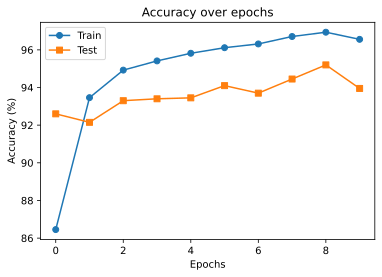

In [34]:
# Run the model without changing the weights; this will be the baseline performance.
# Notice the model creation is outside the function2train
net_base,lossfun,optimizer = createTheMNISTNet()
trainAcc_base,testAcc_base,losses,net_base = function2trainTheModel(net_base,lossfun,optimizer)

# plot the results
plt.plot(range(len(trainAcc_base)),trainAcc_base,'o-', range(len(testAcc_base)),testAcc_base ,'s-')
plt.legend(['Train','Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

# Set all the weights of layer 1 to zero

In [35]:
# Change the weights before training
net_zero,lossfun,optimizer = createTheMNISTNet()

# set to zeros
net_zero.fc1.weight.data = torch.zeros_like( net_zero.fc1.weight )

# confirm
net_zero.fc1.weight.data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

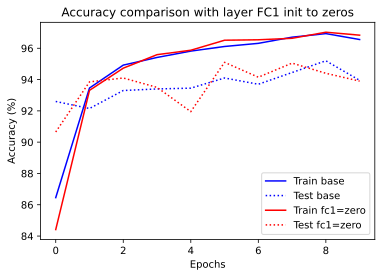

In [36]:
# run the model and show the results
trainAcc_zero,testAcc_zero,losses,net_zero = function2trainTheModel(net_zero,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_zero)),trainAcc_zero,'r-', range(len(testAcc_zero)),testAcc_zero ,'r:')
plt.legend(['Train base','Test base','Train fc1=zero','Test fc1=zero'])
plt.title('Accuracy comparison with layer FC1 init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

tensor([[-0.4815, -0.0554, -0.6590,  ..., -0.0536, -0.9705, -0.7897],
        [-0.3148, -0.0471,  0.4938,  ..., -0.0568,  0.2420,  0.3212],
        [ 0.6396,  0.0743,  0.4434,  ..., -0.0231, -1.4431, -0.8396],
        ...,
        [ 0.4224, -0.0616,  0.0471,  ...,  0.2053,  0.1257, -0.0677],
        [-0.0097,  0.1075,  0.1513,  ..., -0.1603, -0.3465, -1.0116],
        [-0.7359,  0.1136,  0.0777,  ..., -0.0380,  0.4327,  0.2950]])


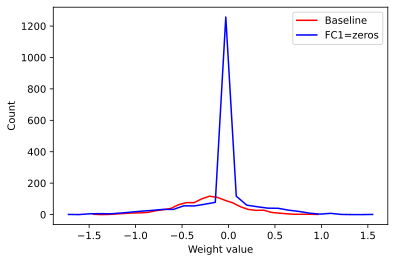

In [39]:
# Are the weights still zeros?
print(net_base.fc1.weight.data)

# show the distributions in a histogram
y,x = np.histogram(net_base.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_zero.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='FC1=zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

In [30]:
y

array([48, 33, 34, 26, 22, 30, 28, 28, 39, 38, 36, 42, 39, 37, 28, 35, 34,
       26, 45, 29, 39, 38, 33, 25, 44, 34, 35, 30, 44, 25])

# Let's repeat the experiment with all learnable parameters set to zero

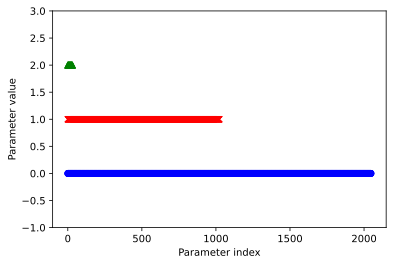

In [40]:
# Change the weights before training
net_allzero,lossfun,optimizer = createTheMNISTNet()

# loop over parameters and set them all to zeros
for p in net_allzero.named_parameters():
  p[1].data = torch.zeros_like( p[1].data )


# and confirm for a few select parameters (y-axis offset for visibility)
plt.plot(0+net_allzero.fc1.weight.data.flatten(),'bo')
plt.plot(1+net_allzero.fc2.weight.data.flatten(),'rx')
plt.plot(2+net_allzero.fc1.bias.data.flatten(),'g^')
plt.xlabel('Parameter index')
plt.ylim([-1,3])
plt.ylabel('Parameter value')
plt.show()

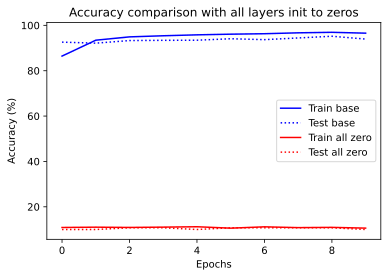

In [41]:
# run the model and show the results
trainAcc_allzero,testAcc_allzero,losses,net_allzero = function2trainTheModel(net_allzero,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allzero)),trainAcc_allzero,'r-', range(len(testAcc_allzero)),testAcc_allzero ,'r:')
plt.legend(['Train base','Test base','Train all zero','Test all zero'])
plt.title('Accuracy comparison with all layers init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

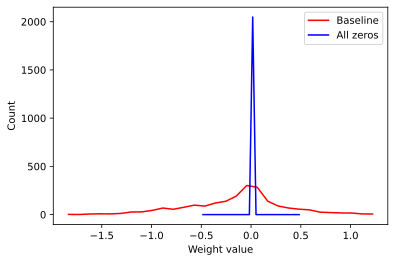

In [44]:
# show the distributions in a histogram
y,x = np.histogram(net_base.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_allzero.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='All zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

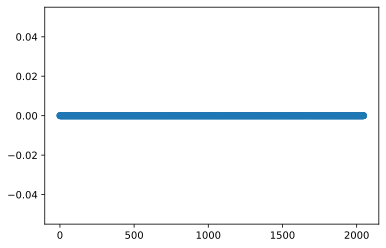

In [45]:
# woah, not even a single non-zero weight value?!?!!?!!??
plt.plot(net_allzero.fc1.weight.data.flatten(),'o');

# Maybe zero is problematic. What about initializing to 1's?

In [ ]:
# Change the weights before training
net_allone,lossfun,optimizer = createTheMNISTNet()
for p in net_allone.named_parameters():
  p[1].data = torch.zeros_like( p[1].data ) + 1
  #p[1].data = torch.zeros( p[1].data.shape ) + 1 # equivalent to the previous line!

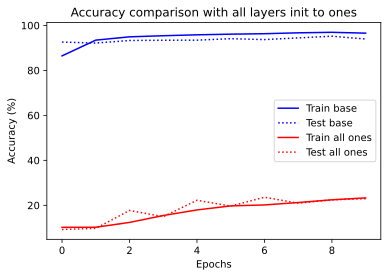

In [46]:
# run the model and show the results
trainAcc_allone,testAcc_allone,losses,net_allone = function2trainTheModel(net_allone,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allone)),trainAcc_allone,'r-', range(len(testAcc_allone)),testAcc_allone ,'r:')
plt.legend(['Train base','Test base','Train all ones','Test all ones'])
plt.title('Accuracy comparison with all layers init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

# Additional explorations

In [ ]:
# 1) You saw that initializing only the weights in fc1 still allowed for good performance, while having all weights be
#    the same value led to HORRIBLE performance. Try setting all weights to ones and all biases to zeros (across all
#    layers). Does that allow for learning? If so, how does it compare to the baseline model performance?
# 
# 2) Now try setting all the weights from all layers to zeros, but leave the bias terms with their initial random values.
# 
# 3) Finally, the opposite of #2: Set all bias terms to zero and leave the weights random. Make a plot of test accuracy
#    performance for the baseline model, weights=0, and biases=0.
# 

## weights to 1 and biases to 0:

In [108]:
net_allone,lossfun,optimizer = createTheMNISTNet()

In [109]:
for i in net_allone.named_parameters():
  if 'weight' in i[0]:
    i[1].data=torch.ones_like( i[1].data )
  else:
    i[1].data=torch.zeros_like( i[1].data )

In [110]:
for i in net_allone.named_parameters():
  if 'bias' in i[0]:
    print(i[1].data)
  else:
    print(i[1].data)

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ...,

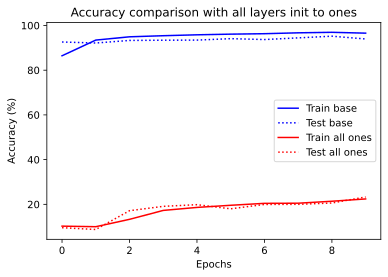

In [111]:
# run the model and show the results
trainAcc_allone,testAcc_allone,losses,net_allone = function2trainTheModel(net_allone,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allone)),trainAcc_allone,'r-', range(len(testAcc_allone)),testAcc_allone ,'r:')
plt.legend(['Train base','Test base','Train all ones','Test all ones'])
plt.title('Accuracy comparison with all layers init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

## weights to 0 and biases to initial random values:

In [89]:
net_allone,lossfun,optimizer = createTheMNISTNet()

In [90]:
for i in net_allone.named_parameters():
  if 'weight' in i[0]:
    i[1].data=torch.zeros_like( i[1].data )

In [91]:
for i in net_allone.named_parameters():
  if 'bias' in i[0]:
    print(i[1].data)
  else:
    print(i[1].data)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([-2.7266e-02, -1.9436e-03, -3.0774e-03,  3.3402e-02, -1.0848e-02,
         1.0679e-03,  3.1983e-02, -3.4340e-02, -1.2940e-02,  6.4515e-03,
         3.4831e-02, -2.1034e-02,  1.2741e-02, -1.4388e-02, -3.3071e-02,
        -9.1054e-03,  3.1643e-02, -2.4269e-02,  2.3298e-02,  7.4540e-04,
        -1.1730e-02,  1.8061e-02, -2.9390e-02,  3.5237e-02,  2.4357e-02,
        -1.8212e-02,  1.3110e-02,  6.8515e-03,  2.2670e-02, -1.7638e-03,
         9.6121e-05, -2.0544e-03,  2.7899e-03, -3.3663e-02,  3.0185e-03,
        -4.4693e-03,  2.9621e-02, -3.7802e-03, -2.0319e-02,  2.1388e-02,
         3.3558e-02, -1.7535e-02, -2.7406e-03, -2.1502e-02, -3.1986e-02,
         2.7674e-02, -1.0495e-02, -2.3831e-02,  2.5161e-02,  1.4548e-02,
        -1.8190e

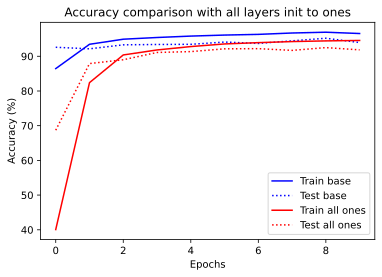

In [92]:
# run the model and show the results
trainAcc_allone,testAcc_allone,losses,net_allone = function2trainTheModel(net_allone,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allone)),trainAcc_allone,'r-', range(len(testAcc_allone)),testAcc_allone ,'r:')
plt.legend(['Train base','Test base','Train all ones','Test all ones'])
plt.title('Accuracy comparison with all layers init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

## weights to initial random values and biases to 0:

In [93]:
net_allone,lossfun,optimizer = createTheMNISTNet()

In [94]:
for i in net_allone.named_parameters():
  if 'bias' in i[0]:
    i[1].data=torch.zeros_like( i[1].data )

In [95]:
for i in net_allone.named_parameters():
  if 'bias' in i[0]:
    print(i[1].data)
  else:
    print(i[1].data)

tensor([[ 0.0021, -0.0114, -0.0004,  ...,  0.0290,  0.0274, -0.0284],
        [-0.0129, -0.0181,  0.0022,  ..., -0.0206, -0.0124, -0.0114],
        [ 0.0348, -0.0299, -0.0343,  ..., -0.0347, -0.0063,  0.0243],
        ...,
        [ 0.0262,  0.0050,  0.0156,  ..., -0.0114,  0.0140,  0.0222],
        [-0.0036,  0.0161,  0.0147,  ...,  0.0203,  0.0128, -0.0024],
        [ 0.0004,  0.0175, -0.0051,  ..., -0.0165,  0.0079, -0.0202]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[-0.1224, -0.0091,  0.1007,  ..., -0.0137,  0.0882, -0.0471],
        [ 0.1079,  0.0628,  0.0553,  ...,  0.0170, -0.0725,  0.0046],
        [-0.0130, -0.0072, -0.0531,  ...,  0.0994,  0.0537, -0.0877],
        ...,
        [ 0.0962, -0.0020,  0.1195,  ..., -0.0745, -0.0829,  0

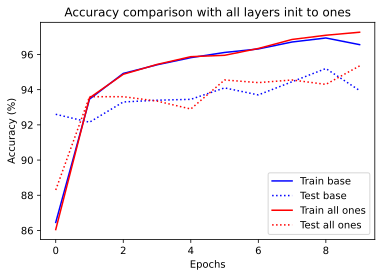

In [96]:
# run the model and show the results
trainAcc_allone,testAcc_allone,losses,net_allone = function2trainTheModel(net_allone,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allone)),trainAcc_allone,'r-', range(len(testAcc_allone)),testAcc_allone ,'r:')
plt.legend(['Train base','Test base','Train all ones','Test all ones'])
plt.title('Accuracy comparison with all layers init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()